# <center>  Notebook S10. Dimer Coagulation and Isolation </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 

This notebook demonstrates calculations related to the configuration where two DMAs are used to size select particles of opposite charge. The two populations are merged and allowed to coagulate. Coagulated dimers are isolated using an electrostatic filter. The dimers are charge neutralized and the size distribution is measured using a DMA operated in stepping or scanning mode. The notebook is a supplement to the manuscript <br>

Petters, M. D. (2018) <i> A language to simplify computation of differential mobility analyzer response functions</i>, Aerosol Science & Technology. <br>

The dimer preparation method was first described by Maisels et al. (2000). Rothfuss and Petters (2016) extended the method to study aerosol viscosity. Since then, the extended technique has been applied in published (Rothfuss and Petters, 2017, Marsh et al., 2018) and unpublished work. As noted in Rothfuss and Petters (2016), the response function of the setup is complex. Only the main peak of the response distribution has been used for interpretation. This notebook is to demonstrate how the response function for the dimer coagulation and isolation system can be modeled. Figure 1 summarizes a typical instrument configuration for the setup.   <br>

<img src="Figures/nbs10_f01.png" width="800">
<figcaption><b> Figure 1. </b>  Schematic of the dual tandem DMA setup.  </figcaption> 

Dried, charge equilibrated particles are classified in DMA1 and DMA2. One DMA is operated with a positive polarity and one with negative polarity power supply, transmitting negatively charged (black) and postively charged (red) particles, respectively. Monodisperse particle concentrations are monitored for both DMAs. The remaining sample flows are merged into a continous flow coagulation chamber with plug flow residence time 10 s < $t$ < 180 s. Particles that underwent coagulation with +1/-1 charge or +2/-2 charges are charge neutral (grey). Also particles that collide with ions in the chamber may revert from being charged to charge neutral monomers. At the exit of the chamber all charged particles are removed with an electrostatic filter. The remaining charge neutral particles are passed through a bipolar charger to reinstate charge equilibrium. Then the size distribution is measured using the third DMA that is operated in scanning or stepping mode, resulting in the function for DMA 3.

To model the response function for DMA 3, the coagulation is conceptualized as follows. Two aerosol populations with identities "1" and "2" are introduced into in the chamber. Each population has unique and defined chemical composition, charge state (0, ±1, or ±2) and size distribution (𝕟₁ and 𝕟₂). Both distributions have the same mode diameter. Chemical composition and charge state are identical for particles within a population. It is assumed that there are no wall losses in the chamber. With these assumptions, the size distribution of +k/-k dimers is then given by (Notebook S11) <br> <br>

<center> $𝕟_{1,2} = f$⋅$\left[\left(\beta_{1,2}^{z(k_1,k_2)}*t\right)*\left(𝕟_1.*𝕟_2\right)\right]$ </center>

where $t$ is time elapsed, $\beta_{1,2}^{z(k_1,k_2)}$ is the Zebel-corrected Brownian coagulatation rate (Zebel, 1958, Jacobson, 2005, Notebook S11), $f = \sqrt[3]{2}$, $⋅$ is the operator that shifts the distribution along the diameter axis, $*$ is the operator that scales the concentration of a distribution, $.*$ is the operator that computes square of two size distributions (Notebook S3). The factor $f$ accounts for the increase in sphere equivalent volume of the formed dimers. The Zebel-corrected Brownian coagulatation rate can be computed if temperature, pressure, and particle densities are known or assumed. The above expression models the dimer size distribution to first approximation, as is demonstrated via comparison with predictions from the particle-resolved Monte Carlo code for atmospheric aerosol simulation (PartMC) (Riemer et al., 2009,  Tian 2017, Notebook S11). 

Production of neutral particles due to ion collisions is assumed to follow a first order process
<center> $\frac{dN}{dt} = \beta_d N$ </center>

where $\beta_d$ is the decharge rate. If it is further assumed that the collision rate is independent with size (within the narrow bounds of quasi-monodisperse population), that positive and negative ion concentrations are the same, and that the number of decharged particles remains small relative to the total population, the decharge size distribution can be written as

<center> $𝕟_d = \beta_d*t*(𝕟_1 + 𝕟_2)$ </center>

The code below demonstrates how to compute the response function of DMA3. The numbers mimic an experiment reported in Rothuss in Petters (2016) as best as possible. The remaining numbers are assumed. 

## Block 1. Dependencies

In [1]:
using Plots, Plots.PlotMeasures, DifferentialMobilityAnalyzers, LinearAlgebra, Printf
plotlyjs();

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

## Block 2. Setup Three DMAs
Note that all three DMAs here are assumed to be of the TSI geometry and identical flow ratios. In our past work we used DMAs with different designs, dimensions, and flow rates for DMA1, DMA2, and DMA3. This can be easily implemented assinging Λ1, Λ2, Λ3 different dimensions, but is not done here for simplicity. Flow ratios of 1/3 are assumed for DMAs 1 and 2 and 1/10 for DMA3. These values approximate conditions in Rothuss in Petters (2016).

In [2]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/10                            # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 2                                            # Upper number of charges
β₁ = 1.0/3.0      # Sample-to-sheath ratio DMA1
β₂ = 1.0/3.0      # Sample-to-sheath ratio DMA2
β₃ = 1.0/10.0     # Sample-to-sheath ratio DMA3
Λ₁ = DMAconfig(t,p,qsa,qsa/β₁,r₁,r₂,l,leff,:-,m,:cylindrical)  # Specify DMA with negative polarity
Λ₂ = DMAconfig(t,p,qsa,qsa/β₂,r₁,r₂,l,leff,:+,m,:cylindrical)  # Specify DMA with positive polarity
Λ₃ = DMAconfig(t,p,qsa,qsa/β₃,r₁,r₂,l,leff,:-,m,:cylindrical)  # Specify DMA with negative polarity
bins,z₁,z₂ = 512, dtoz(Λ₁,500e-9),dtoz(Λ₁,20e-9)  # bins, upper, lower mobility limit
δ₁ = setupDMA(Λ₁, z₁, z₂, bins)                   # Compute matrices
δ₂ = setupDMA(Λ₂, z₁, z₂, bins)                   # Compute matrices
δ₃ = setupDMA(Λ₃, z₁, z₂, bins);                  # Compute matrices

## Block 2. Initial Conditions
A selected size in DMA 1 and 2 of 50 nm and a coagulation time of 8s is set to mimic one experiment in Rothuss in Petters (2016). The decharge rate kᵈ and the upstream size distribution are assumed. These were unknown/not measured in Rothuss in Petters (2016). 

In [3]:
Dₘ = 50.0                       # Size select 60 nm mobility diameter
zˢ = dtoz(Λ₁, Dₘ*1e-9);         # Compute corresponding electrical mobility
β₁₂ = map(k->β12(ztod(Λ₁,k,zˢ)*1e-9, ztod(Λ₂,k,zˢ)*1e-9, k,-k),1:m) # rate for +i/-i charges
βᵈ = 3e-5                       # kd is the rate of spontaneous decharge [s-1], number is a guess
f = 2.0^(1.0/3.0)               # diameter shift of dimers (Dₘ^3+Dₘ^3)^(1/3)/Dₘ
t = 8.0                         # time to coagualate 
𝕟ᶜⁿ = DMALognormalDistribution([[1e12, 30., 1.4], [4e12, 80., 1.5]], δ₁);   # Returns a size distribution 

## Block 3. Compute Distributions
_Part 1._ The function T is the size selection function used in Notebook S4, S8, and S9. The size distributions 𝕟ᵖ and 𝕟ᵐ denote plus and minus charged particles based on the DMA polarity selected in Block 1. The map function produces an array of SizeDistributions for charges k = 1..n. Here n = 2 is selected (Block 1) for both clarity and because +3/-3 coagulation events are too rare to produce appreciable concentrations in the current version of the instrument. The distribution 𝕟ᵗ is simply the sum of the individual charge distributions.
```julia 
T = (k,Zs,Λ,δ) -> Ω(Λ,δ.z,Zs./k) .* δ.Tc(k) .* δ.Tl(Λ,δ.dp)
𝕟ᵖ = map(k -> T(zˢ,k,Λ₁,δ₁)*𝕟ᶜⁿ,1:m)
𝕟ᵐ = map(k -> T(zˢ,k,Λ₂,δ₂)*𝕟ᶜⁿ,1:m)
𝕟ᵗ = sum(𝕟ᵐ + 𝕟ᵖ);
```
_Part 2._ The distribution 𝕟ᵈ is the decharge distribution. Only singly charged particles are assumed to decharge; therefore the decharge rate is tied to 𝕟ᵐ[1] and 𝕟ᵖ[1]. The coagulated distributions, 𝕔, are computed as described above. Note that β₁₂[k] is the Zebel correct rate for +k,-k charges calculated in Block 2. The distribution 𝕔ᵗ is simply the sum of the individual coagulated distributions and the decharge distribution.
```julia 
𝕟ᵈ = βᵈ*t*(𝕟ᵐ[1] + 𝕟ᵖ[1]);
𝕔  = map(k -> f⋅((β₁₂[k]*t)*(𝕟ᵐ[k]*𝕟ᵖ[k])), 1:m) 
𝕔ᵗ = sum(𝕔) + 𝕟ᵈ
```
_Part 3._ The 𝕤 distributions are those that have been transmitted through the bipolar charger and third DMA. The tranfer is modeled using the convoution matrix A with the size distribution.
```julia 
𝕤  =  map(k -> δ₃.𝐀*𝕔[k],1:n)
𝕤ᵈ =  δ₃.𝐀*𝕟ᵈ                   
𝕤ᵗ =  δ₃.𝐀*𝕔ᵗ;                    
```

In [4]:
T = (zˢ,k,Λ,δ) -> δ.Ω(Λ,δ.Z,zˢ/k).*δ.Tc(k,δ.Dp).*δ.Tl(Λ,δ.Dp)

𝕟ᵖ = map(k -> T(zˢ,k,Λ₁,δ₁)*𝕟ᶜⁿ,1:m)
𝕟ᵐ = map(k -> T(zˢ,k,Λ₂,δ₂)*𝕟ᶜⁿ,1:m)
𝕟ᵗ = sum(𝕟ᵐ + 𝕟ᵖ);

𝕟ᵈ = βᵈ*t*(𝕟ᵐ[1] + 𝕟ᵖ[1]);
ℂ = map(k -> f⋅((β₁₂[k]*t)*(𝕟ᵐ[k]*𝕟ᵖ[k])), 1:m) 
𝕔ᵗ = sum(ℂ) + 𝕟ᵈ

𝕊  =  map(k -> δ₃.𝐀*ℂ[k],1:m)
𝕤ᵈ =  δ₃.𝐀*𝕟ᵈ                   
𝕤ᵗ =  δ₃.𝐀*𝕔ᵗ;                  

## Block 4. Visualize Results

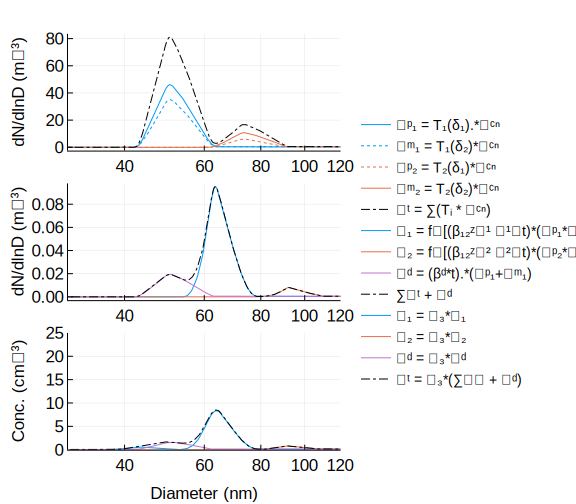

In [5]:
figure("Nimbus Sans L", 2, 4, 3.5, 8)

pre = 1e-10
# Get a list of colors from the theme palette
p = Plots.get_color_palette(:auto, default(:bgcolor), 100)

# Panel 1
p1 = plot(𝕟ᵖ[1].Dp,pre*𝕟ᵐ[1].S, xaxis = :log10, xlim = (40,400), ylabel = "dN/dlnD (m⁻³)", 
    label = "𝕟ᵖ₁ = T₁(δ₁).*𝕟ᶜⁿ", color = p[1])
p1 = plot!(𝕟ᵐ[1].Dp,pre*𝕟ᵖ[1].S, ls = :dot,  label = "𝕟ᵐ₁ = T₁(δ₂)*𝕟ᶜⁿ", color = p[1])
p1 = plot!(𝕟ᵖ[2].Dp,pre*𝕟ᵖ[2].S, ls = :dot, label = "𝕟ᵖ₂ = T₂(δ₁)*𝕟ᶜⁿ", color = p[2])   
p1 = plot!(𝕟ᵐ[2].Dp,pre*𝕟ᵐ[2].S, label = "𝕟ᵐ₂ = T₂(δ₂)*𝕟ᶜⁿ", color = p[2])   
p1 = plot!(𝕟ᵗ.Dp,pre*𝕟ᵗ.S, color = :black, label = "𝕟ᵗ = ∑(Tᵢ * 𝕟ᶜⁿ)", ls = :dashdot)  

# Panel 2
p2 = plot(ℂ[1].Dp,pre*ℂ[1].S, xaxis = :log10, xlim = (40,400), 
    ylabel = "dN/dlnD (m⁻³)", label = "ℂ₁ = f⋅[(β₁₂ᶻ⁽¹ ⁻¹⁾t)*(𝕟ᵖ₁*𝕟ᵐ₁)]")
p2 = plot!(ℂ[2].Dp,pre*ℂ[2].S, label = "ℂ₂ = f⋅[(β₁₂ᶻ⁽² ⁻²⁾t)*(𝕟ᵖ₂*𝕟ᵐ₂)]")   
p2 = plot!(𝕟ᵈ.Dp,pre*𝕟ᵈ.S, label = "𝕟ᵈ = (βᵈ*t).*(𝕟ᵖ₁+𝕟ᵐ₁)", color = p[4])   
p2 = plot!(𝕔ᵗ.Dp,pre*𝕔ᵗ.S, color = :black, label = "∑𝕔ᵗ + 𝕟ᵈ", ls = :dashdot)   
 
# Panel 3
pre = 1e-6     # Note change in units from m-3 to cm-3
p3 = plot(𝕊[1].Dp,pre*𝕊[1].N, xaxis = :log10, xlim = (40, 400), ylabel = "Conc. (cm⁻³)", ylim = (0,25),
    xlabel = "Diameter (nm)", label = "𝕊₁ = 𝐀₃*ℂ₁")
p3 = plot!(𝕊[2].Dp,pre*𝕊[2].N,  label = "𝕊₂ = 𝐀₃*ℂ₂")   
p3 = plot!(𝕤ᵈ.Dp,pre*𝕤ᵈ.N,  label = "𝕤ᵈ = 𝐀₃*𝕟ᵈ", color = p[4])   
p3 = plot!(𝕤ᵗ.Dp,pre*𝕤ᵗ.N, color = :black, label = "𝕤ᵗ = 𝐀₃*(∑ℂₖ + 𝕟ᵈ)", ls = :dashdot)   

plot(p1,p2,p3, layout = grid(3,1), left_margin = 40px,right_margin = 25px,legend=:right, 
    top_margin = 15px, xlim = (30,120), fmt = :svg)

__Figure 2.__ _Top panel._ Size distributions selected from single mobility by DMA1 (negative polarity and positively charged particles, 𝕟ᵖ) and DMA2 (positive polarity and negatively charged particles 𝕟ᵐ).  Blue, and organge correspond to +1, +2 charged particles. The negatively charged particles have higher concentration due to the difference in charging probability. The black dash-dotted line corresponds to the sum of the components. Spectral densities dN/dlnD are multiplied by 10⁻¹⁰ to keep axis labels readable. _Middle panel._ Size distribution of particles after passage through the electrostatic filter. Blue corresponds to dimers from +1/-1 coagulation events, orange to dimers from +2/-2 coagulation events, and purple from particle discharge. The dash-dotted black line corresponds to the sum of the components. Spectral densities dN/dlnD are multiplied by 10⁻¹⁰ to keep axis labels readable. _Bottom panel._ Size distribution particles after passage through DMA3. Blue, organge, and purple correspond size distributions of +1, +2, decharged particles in the middle panel. The black dashdotted line corresponds the sum of all components. 

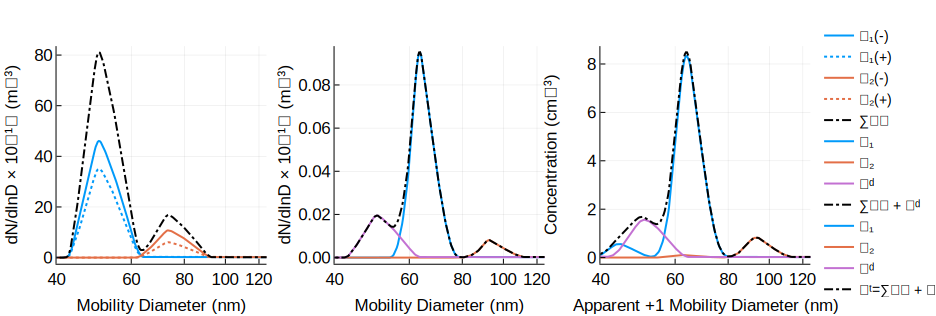

In [6]:
figure("Nimbus Sans L", 2, 6.5, 2.2, 8)

pre = 1e-10
# Get a list of colors from the theme palette
p = Plots.get_color_palette(:auto, default(:bgcolor), 100)

# Panel 1
p1 = plot(𝕟ᵖ[1].Dp,pre*𝕟ᵐ[1].S, xaxis = :log10, xlim = (40,400), ylabel = "dN/dlnD × 10⁻¹⁰ (m⁻³)", 
    label = "ℕ₁(-)", color = p[1], xlabel = "Mobility Diameter (nm)", left_margin = 20px)
p1 = plot!(𝕟ᵐ[1].Dp,pre*𝕟ᵖ[1].S, ls = :dot,  label = "ℕ₁(+)", color = p[1])
p1 = plot!(𝕟ᵐ[2].Dp,pre*𝕟ᵐ[2].S, label = "ℕ₂(-)", color = p[2])   
p1 = plot!(𝕟ᵖ[2].Dp,pre*𝕟ᵖ[2].S, ls = :dot, label = "ℕ₂(+)", color = p[2])   
p1 = plot!(𝕟ᵗ.Dp,pre*𝕟ᵗ.S, color = :black, label = "∑ℕₖ", ls = :dashdot)  

# Panel 2
p2 = plot(ℂ[1].Dp,pre*ℂ[1].S, xaxis = :log10, xlim = (40,400), 
    ylabel = "dN/dlnD × 10⁻¹⁰ (m⁻³)", label = "ℂ₁", xlabel = "Mobility Diameter (nm)")
p2 = plot!(ℂ[2].Dp,pre*ℂ[2].S, label = "ℂ₂")   
p2 = plot!(𝕟ᵈ.Dp,pre*𝕟ᵈ.S, label = "𝕟ᵈ", color = p[4])   
p2 = plot!(𝕔ᵗ.Dp,pre*𝕔ᵗ.S, color = :black, label = "∑ℂₖ + 𝕟ᵈ", ls = :dashdot)   
 
# Panel 3
pre = 1e-6     # Note change in units from m-3 to cm-3
p3 = plot(𝕊[1].Dp,pre*𝕊[1].N, xaxis = :log10, xlim = (40, 400), ylabel = "Concentration (cm⁻³)", 
    xlabel = "Diameter (nm)", label = "𝕊₁",left_margin = 30px, right_margin = 10px)
p3 = plot!(𝕊[2].Dp,pre*𝕊[2].N,  label = "𝕊₂")   
p3 = plot!(𝕤ᵈ.Dp,pre*𝕤ᵈ.N,  label = "𝕤ᵈ", color = p[4])   
p3 = plot!(𝕤ᵗ.Dp,pre*𝕤ᵗ.N, color = :black, label = "𝕤ᵗ=∑𝕊ₖ + 𝕤ᵈ", ls = :dashdot, 
    xlabel = "Apparent +1 Mobility Diameter (nm)")   

plot(p1,p2,p3, layout = grid(1,3), legend=:right, top_margin = 30px, xlim = (40,125), lw = 2, fmt = :svg)

__Figure 3.__ Same as Figure 2, but with abbreviated legend and different orientation. 

## Block 5. Compute Observables
There are several direct observables in the system that can be used as a guide during experiments. These are the total number concentration exiting DMA1 and DMA2, the peak number concentration of the coagulated peak and the number concentration of particles exiting the electrostatic filter. These are readily computed from the distributions.

In [7]:
@printf("Number concentration after DMA 1: %i cm-3\n", sum((sum(𝕟ᵐ)).N)*1e-6)
@printf("Number concentration after DMA 2: %i cm-3\n", sum((sum(𝕟ᵖ)).N)*1e-6)
@printf("Number concentration after electrostatic filter: %i cm-3\n", sum(𝕤ᵗ.N)*1e-6)
@printf("Number concentration at peak during DMA3 scan: %i cm-3\n", maximum(𝕤ᵗ.N)*1e-6)

Number concentration after DMA 1: 116153 cm-3
Number concentration after DMA 2: 84055 cm-3
Number concentration after electrostatic filter: 337 cm-3
Number concentration at peak during DMA3 scan: 8 cm-3


## Summary and Conclusions
The example trimodal DMA3 response function shown in Figure 3 compares well with Figure 3b in Rothfuss and Petters (2016). The instrument parameters used in the simulation are similar to those used in that study. However, it needs to be pointed out that the inputs size distribution and decharge rate had to be assumed. Therefore a quantitative comparison between modeled and observed response function is not possible. The actual structure of the DMA 3 response functions varies greatly with particle number concentration, shielding, upstream size distribution, and flow ratios. Exploring this parameter space and quantitative comparisons between the DMA transfer theory, coagulation theory, and well constraomed observations beyond the scope of this work and will be expolred in a seperate study. 

The distributions graphed in Figure 2 can be succintly generated with 10 lines of code (Block 3) using the language specifications introduced in this work. The code can easily modified to explore the DMA3 response function for a wide range of inpute conditions.

## References

Jacobson, M. Z. (2005) Fundamentals of Atmospheric Modeling. Second Edition, Cambridge University Press. 

Maisels, A., Kruis, F. E., Fissan, H., Rellinghaus, B., and Zähres, H. (2000). Synthesis of Tailored Composite Nanoparticles in the Gas Phase. Appl. Phys. Lett., 77:4431–4433.

Marsh, A., S. S. Petters, N. E. Rothfuss, G. Rovellia, Y. C. Song, J. P. Reid, and M. D. Petters (2018) Amorphous Phase State Diagrams and Viscosity of Ternary Aqueous Organic/Organic and Inorganic/Organic Mixtures, Physical Chemistry Chemical Physics, in press.

Riemer, N.,  M. West, R. A. Zaveri, and R. C. Easter (2009) Simulating the evolution of soot mixing state with a particle-resolved aerosol model, Journal of Geophysical Research 114(D09202), DOI:10.1029/2008JD011073. 

Rothfuss, N.E. & M. D. Petters (2016) Coalescence-based assessment of aerosol phase state using dimers prepared through a dual-differential mobility analyzer technique, Aerosol Science and Technology, 50:12, 1294-1305, DOI:10.1080/02786826.2016.1221050

Rothfuss, N. E. and M. D. Petters (2017), Characterization of the temperature and humidity-dependent phase diagram of amorphous nanoscale organic aerosol, Physical Chemistry Chemical Physics, 19, 6532-6545, doi:10.1039/C6CP08593H.

Tian, J., B. T. Brem, M. West, T. C. Bond, M. J. Rood & N. Riemer (2017) Simulating aerosol chamber experiments with the particle-resolved aerosol model PartMC, Aerosol Science and Technology, 51:7, 856-867, DOI:10.1080/02786826.2017.1311988

Zebel, G. (1957) Zur Theorie des Verhaltens elektrisch geladener Aerosole, Kolloid-Zeitschrift, (1), 37–50, DOI:10.1007/BF01734032.